# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Clustering based strategy

In this notebook, we will create a strategy using the K-Means algorithm and the Simple Moving Average (SMA). 
The strategy works as follows:
1. Fetch the minute data for Ethereum/USDT from a csv file
2. Convert the UNIX epoch time to normal datetime format and set it as index
3. Compute the SMA values for with a lookback period of 30 minutes
4. Compute the past movement to indicate the volatility of the market
5. Calculate the market return values
6. Train the K-Means on the train data
7. Predict the clusters
8. Generate the signals
9. Compute the strategy returns after slippage 
10. Plot the strategy returns
11. Compute the net profit

## Import data and libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import talib as ta
from sklearn.cluster import KMeans

In [2]:
# Read 1-min data
df1 = pd.read_csv('../data_modules/1min_ETHUSDT.csv').iloc[-100000:]

# Set the timestamp to be the index for the data
df1 = df1.set_index('Timestamp')

### Convert the Unix timestamp to datetime

In [3]:
df1.index = pd.to_datetime(df1.index, unit='ms')

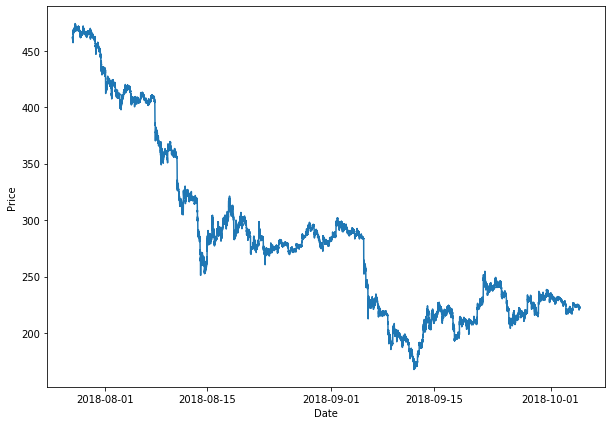

In [4]:
# Let us visualize the data to confirm if it really was trending for the given time frame
plt.figure(figsize=(10, 7))
plt.plot(df1.Close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Compute the SMA, movement and market return

In [5]:
# We use the past Close price to calculate the SMA, and Movement
df1['SMA'] = df1.Close.shift(1).rolling(30).mean()

# Calculate the absolute value of percentage change in prices this will be used as input for the K-means
df1['Movement'] = df1.Close.shift(1).pct_change().abs()

# We Calculate the market return values
df1['Return'] = df1.Close.pct_change()

# Drop all the null values
df1 = df1.dropna()

In [6]:
# The length of total data is
len(df1)

99970

In [7]:
# Let us assign a variable to signify the 25% of total data
t = int(0.25*len(df1))
t

24992

### Create a column to contain the cluster values

In [8]:
df1['Cluster'] = 0

#### We are using the past initial 75% data to train the clustering algorithm.

In [9]:
# Instantiate a K-Means model
clus = KMeans(2)

# Fit the K-Means model to the train data to train the model. Here we need to reshape the data
# as the input contains a single column
clus.fit(np.reshape(df1.Movement.iloc[:-t].values, (-1, 1)))

# Assign the predicted cluster values to the cluster column. We use the predict function to predict the cluster values
df1.Cluster = clus.predict(np.reshape(df1.Movement.values, (-1, 1)))

### Volatility Cluster centres

In [10]:
print("Centre of Cluster 0 ", clus.cluster_centers_[0][0])
print("Centre of Cluster 1 ", clus.cluster_centers_[1][0])

Centre of Cluster 0  0.0005109694678958357
Centre of Cluster 1  0.0029761579983422367


#### Here we can see that Cluster 0's centre is less than the Cluster 1's, indicating that Cluster 0 contains the market datapoints which have less movement and are the low voaltity data points which we want to trade.

In [11]:
# To check the number of high volatility data points in cluster 1
df1.Cluster.iloc[-t:].sum()

3586

### Generate the trend trading signals

In [12]:
df1['Signal'] = 0

# If the datapoint belongs to Cluster 0, and the SMA < Close then we sell in the market. This is indicated by the -1.
df1['Signal'] = np.where(
    ((df1.SMA > df1.Close.shift(1)) & (df1.Cluster == 0)), -1, df1.Signal)

# If the datapoint belongs to Cluster 0, and the SMA > Close then we sell in the market. This is indicated by the 1.
df1['Signal'] = np.where(
    ((df1.SMA < df1.Close.shift(1)) & (df1.Cluster == 0)), 1, df1.Signal)

### Compute the Strategy returns 

In [13]:
# We can compute the strategy returns by multiplying the trading signals with return values.
# The multiplication will give us values same as the market returns if we are long
# and opposite the market returns if we are short
df1['StrReturn'] = df1.Signal*df1.Return

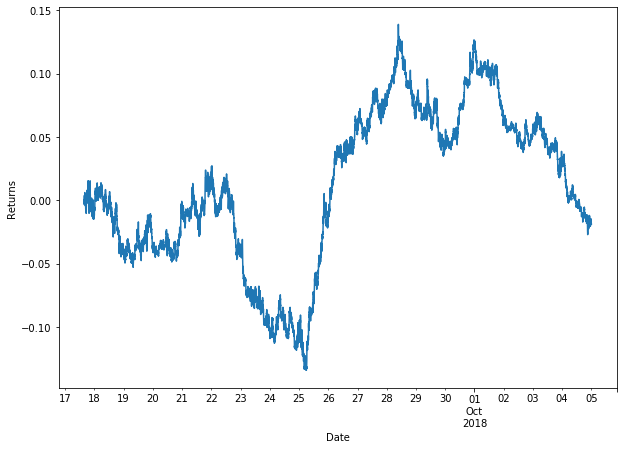

In [14]:
plt.figure(figsize=(10, 7))
Cumulative_Returns = df1.StrReturn.iloc[-t:].cumsum()
Cumulative_Returns.plot()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

### Compute the total slippage cost and net cumulative  returns on the test data (last 25%)

When we execute a strategy based on market orders our strategy can experience a significant slippage,
if the bid-ask prices are far away. So, we have taken an average bid-ask spread of 0.05 based on the order book 
data from crypto exchanges and subtracted this value from every trade.

In [15]:
# Check if a trade is executed in the Signal column, if it has, 
# then subtract the slippage value from the strategy returns
Cumulative_Returns = (
    df1.StrReturn.iloc[-t:]-df1.Signal.iloc[-t:].abs()*(0.05/df1.Close.iloc[-t:])).expanding().sum()

In [16]:
Cumulative_Returns

Timestamp
2018-09-17 15:29:00    0.000000
2018-09-17 15:30:00    0.000000
2018-09-17 15:31:00    0.000000
2018-09-17 15:32:00    0.000000
2018-09-17 15:33:00   -0.000730
2018-09-17 15:34:00   -0.003601
2018-09-17 15:35:00   -0.003601
2018-09-17 15:36:00   -0.003601
2018-09-17 15:37:00   -0.003601
2018-09-17 15:38:00   -0.003601
2018-09-17 15:39:00   -0.003601
2018-09-17 15:40:00   -0.003601
2018-09-17 15:41:00   -0.003601
2018-09-17 15:42:00   -0.003211
2018-09-17 15:43:00    0.002854
2018-09-17 15:44:00    0.002854
2018-09-17 15:45:00    0.002854
2018-09-17 15:46:00    0.002854
2018-09-17 15:47:00    0.000065
2018-09-17 15:48:00    0.000065
2018-09-17 15:49:00    0.000065
2018-09-17 15:50:00   -0.001053
2018-09-17 15:51:00   -0.000422
2018-09-17 15:52:00   -0.003971
2018-09-17 15:53:00   -0.003971
2018-09-17 15:54:00   -0.003777
2018-09-17 15:55:00   -0.006200
2018-09-17 15:56:00   -0.006200
2018-09-17 15:57:00   -0.003383
2018-09-17 15:58:00   -0.003383
                         ...  

### Plot the cumulative returns of the strategy

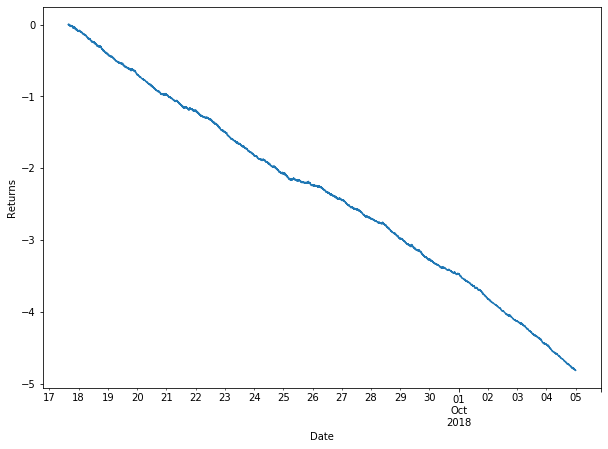

In [17]:
plt.figure(figsize=(10, 7))
Cumulative_Returns.plot()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

### Compute the net profit after slippage

In [18]:
Final_percentage_retuns = (Cumulative_Returns.iloc[-1])*100

In [19]:
Final_percentage_retuns

-481.48332397808423

As we can see the strategy is not profitable, as the trade entry points are not completely optimized yet. To optimize the entry points, we need to use multiple indicators. We will learn how to optimize the entry points using the Hurst exponent in the upcoming sections.